<div class="alert alert-block alert-info">
 
<h1><center>ПРОЕКТ: </center></h1>
<h1><center>"Определение истинности и ложности новостей по их заголовкам"</center></h1>
    
</div>

<div class="alert alert-block alert-success">

**В нашем распоряжении имееется два файла обучающей и тестовой выборки.**
    
**Файл "train.tsv" содержит табличные данные, состояшие из двух колонок: *`'title'`* (заголовки новостей) и *`'is_fake'`* (класс 0 - реальная новость, класс 1 - выдуманная).** 
    
**В файле *`test.tsv`* также есть данные с заголовками новостей, целевую же переменную необходимо предсказать.**

    
<h1><span style="text-decoration:underline">Цель проекта - построить модель, которая будет классифицировать истинность vs ложность новостей по их заголовкам.</span></h1>
    
</div>

**ПЛАН РАБОТЫ:**

**1. Загрузка и анализ информации.**

**2. Подготовка данных к обучению.**

**3. Обучение данных на нескольких моделях и выбор лучшей для ее использование на тесте.**

**4. Предсказание реальных/выдуманных новостей на тестовой выборке.**

<h1><center>В путь!</center></h1>

<img src="https://cdn-images-1.medium.com/max/1600/1%2AlG256YbUI4Cptj8SO1ry0A.gif" width="500">

# Installing wordcloud package

In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


##  Importing libraries

In [2]:
import pandas as pd
import numpy as np

from sklearn import *

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix, roc_curve, roc_auc_score

from wordcloud import WordCloud
from pymystem3 import Mystem
import re, nltk
from nltk.corpus import stopwords

import  matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

## Importing and reading training data

In [3]:
data = pd.read_csv('train.tsv', sep='\t')

In [4]:
data.head(20)

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1
5,Российским студентам запретят учиться за рубежом,1
6,Путин пишет книгу об истории Украины,1
7,Россияне обхитрили рост цен,0
8,Звезда «Ворониных» раскрыл подробности о своем...,0
9,Microsoft объявила дату выхода очков дополненн...,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB


Имеем 5758 строк. На первый взгляд данные выглядят довольно "чистыми": без каких-либо грубых перебоев в регистрах, наличии ненужных символов пр. Пропусков также нет ✔️. 

Посмотрим на распределение классов:

0    2879
1    2879
Name: is_fake, dtype: int64 



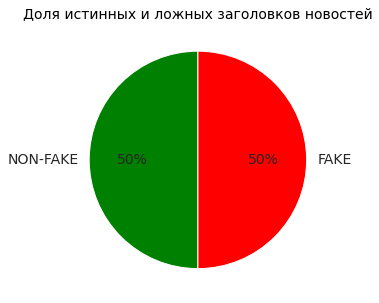

In [6]:
# Fake amd non-fake news ratio

ratio = data['is_fake'].value_counts()
print(ratio, '\n')

plt.figure(figsize=(5,5))
plt.title('Доля истинных и ложных заголовков новостей', fontsize=14, color='black')

labels=['NON-FAKE', 'FAKE']
ratio.plot(kind='pie', startangle=90, textprops={'fontsize': 14},
           labels=labels, autopct = '%0.0f%%', colors = ['green', 'red'])
plt.ylabel('');

Абсолютное равенство - дисбаланс классов отсутвует ✔️.

Проверим дубликаты:

In [7]:
data['title'].duplicated().sum()

1

Один попался. Посмотрим, какой заголовок закрался в данные дважды:

In [8]:
data['title'].value_counts()

В США зафиксировано рекордное количество банкротств                                                                                        2
Российские мужчины массово бьют женщин и дарят им цветы                                                                                    1
В Ольгино объяснили большое количество комментариев под сообщением Володина о QR-кодах                                                     1
«Среди предков Навального - Лжедмитрий I, Салтычиха, Керенский и Ягода»: Институт истории РАН представил генеалогическое древо политика    1
В очередном туре чемпионата России по футболу лидеры потеряли очки                                                                         1
                                                                                                                                          ..
США вслед за Россией возобновят создание сверхзвукового самолета                                                                           1
Россия остала

Ммм..интересно)) удалим дубликат ✔️

In [9]:
data = data.drop_duplicates(subset=['title']) 

Посмотрим внимательнее на заголовки новостей

In [10]:
# Displaying full length title strings on a screen

def display_max_str_width(data, width):
    with pd.option_context('display.max_colwidth', width):
        print(data)

display_max_str_width(data['title'], 100)

0           Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы
1                               Агент Кокорина назвал езду по встречке житейской историей
2             Госдума рассмотрит возможность введения секретных статей Уголовного кодекса
3                               ФАС заблокировала поставку скоростных трамваев для Москвы
4                             Против Навального завели дело о недоносительстве на Волкова
                                              ...                                        
5753                                 Эдди Чемберс получил сотрясение мозга в бою с Кличко
5754                                 Правительство застроит Россию нефтепродуктопроводами
5755    «Мне стыдно перед дедом»: новый канцлер ФРГ обратился с первой речью к Бундестагу
5756                                     Туркмения в декабре начнет поставки газа в Китай
5757                               Бывший тренер Локомотива возглавил нальчикский Спартак
Name: titl

Текстовые данные содержат русский и английский алфавит, цифры и знаки пунктуации. При подготовке текста мы сохраним оба алфавита, числовые данные, но избавимся от всех знаков пунктуации кроме "-". 

Для подготовки заголовков нововстей к обучению на моделях используем:

1. Токенизацию с помощью регулярного выражения;
2. Изменение регистра всех букв на нижний;
3. Лемматизацию только русской части слов;
4. Удаление стоп-слов (также только русского языка)

### Preprocessing textual data

In [11]:
# Text preprocessing

m = Mystem()
stop_words = set(stopwords.words('russian'))

def preprocessing(sent):
    sent =  re.sub(r'[^\w\s-]', ' ', sent)
    sent = sent.lower()
    
    sent =''.join(m.lemmatize(sent)) 
    
    final_sent = []
    for i in sent.split():
        if i.strip() not in stop_words:
            final_sent.append(i.strip())
    return ' '.join(final_sent)


data['lemm_text'] = data['title'].apply(preprocessing) #function applying to the column

Выведим полученные данные на экран:

In [12]:
data.head()

,title,is_fake,lemm_text
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1,москвич владимир клутин приходить счет вмешате...
1,Агент Кокорина назвал езду по встречке житейск...,0,агент кокорин называть езда встречок житейский...
2,Госдума рассмотрит возможность введения секрет...,1,госдума рассматривать возможность введение сек...
3,ФАС заблокировала поставку скоростных трамваев...,0,фас заблокировать поставка скоростной трамвай ...
4,Против Навального завели дело о недоносительст...,1,против навальный заводить дело недоносительств...


In [13]:
data['lemm_text'].iloc[57]

'украина опускаться четвертый место отборочный группа евро-2008'

Данные очищены и лемматезированы. 

Перейдем к небольшому анализу.

### Analyzing textual data

Построим облако слов и посмотрим, какие слова наиболее употребимы в фейковых и не фейковых заголовках:

In [14]:
# Separetind dataset into non-fake & fake news titles

fake = data[data['is_fake']==1]
non_fake = data[data['is_fake']==0]

In [15]:
# Wordcloud function

def disp_wordcloud(data):
    wc = WordCloud(max_words=55, background_color = 'white', 
                   colormap='inferno').generate(' '.join(data['lemm_text'].tolist()))
   
    plt.figure(figsize=(10, 10))
    plt.imshow(wc, interpolation = 'bilinear')
    plt.axis('off');
    plt.tight_layout(pad=0)

**`Non-Fake news wordcloud`**

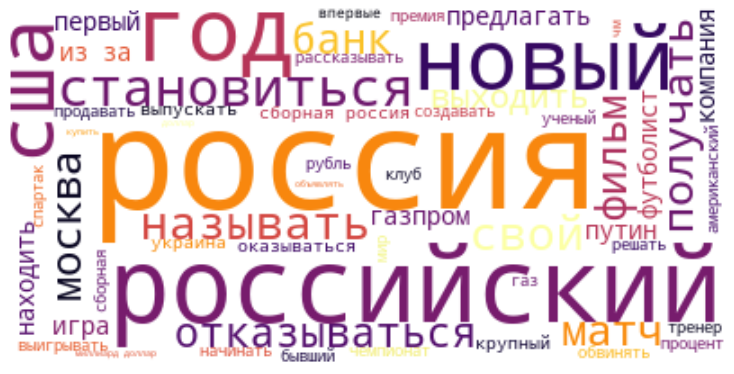

In [16]:
disp_wordcloud(non_fake) #non-fake news wordcloud

**`Fake news wordcloud`**

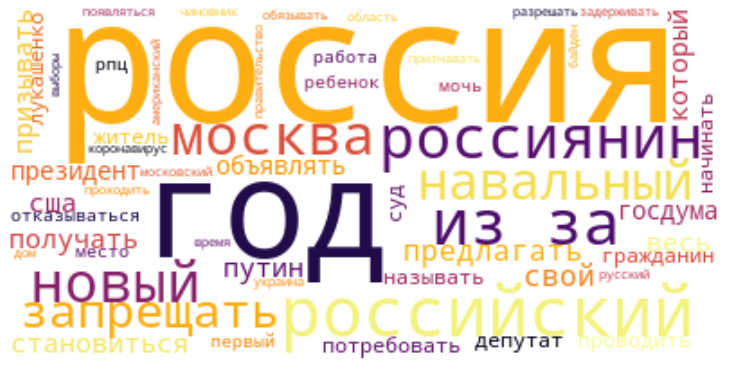

In [17]:
disp_wordcloud(fake) #fake news wordcloud

Россия на первом месте - это понятно. Тем не менее, судя по "облакам", реальные новости более "пестрые", охват тематики шире: не только политика, но и спорт, искусство etc. Ложные же больше сосредоточены на освещении актуальных политических вопросов.

<font color='darkblue'><span style="text-decoration:underline">**ANALYZING OUTLIERS**</span></font>

Проведем некоторый анализ и вычислим среднюю длину предложения и среднее количество слов для обоих классов:

In [18]:
# Calculating mean word numbers & mean sentence lenght in non-fake and fake news titles

data['word_number'] = data['lemm_text'].apply(lambda x: len(str(x).split()))
data['sentence_length'] = data['lemm_text'].apply(lambda x: len(x) - x.count(' '))

print('Истинные новости: ')
print('  •средняя длина слова - ', data[data['is_fake']==0]['word_number'].mean().round(2))
print('  •средняя длина строки - ', data[data['is_fake']==0]['sentence_length'].mean().round(2), '\n')

print('Ложные новости: ')
print('  •средняя длина слова - ', data[data['is_fake']==1]['word_number'].mean().round(2))
print('  •средняя длина строки - ', data[data['is_fake']==1]['sentence_length'].mean().round(2)) 

Истинные новости: 
  •средняя длина слова -  6.17
  •средняя длина строки -  45.13 

Ложные новости: 
  •средняя длина слова -  8.2
  •средняя длина строки -  62.21


Михал Хофман как-то сказал: "*У лжи короткие ноги, но длинные руки*". Что же, чисто с технической точки зрения, у нас и ножки демонстрируют удлиненные пропорции.

Фейковые новости в среднем длинее, чем правдивые.  

Визуализируем данные и посмотрим на распределения c помощью гистограммы и "ящика с усами": 

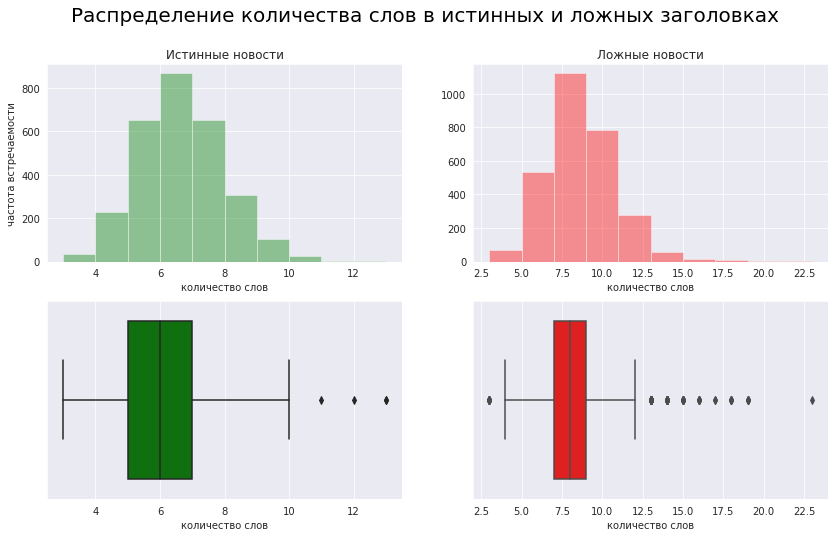

In [19]:
# Visualizing word distribution of non-fake & fake news titles 

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Распределение количеcтва слов в истинных и ложных заголовках', fontsize=20, color='black')


sns.distplot(data[data['is_fake']==0]['word_number'], bins=10,
             kde=False, color='g', ax=axes[0,0]).set(xlabel='количество слов', 
                                                     ylabel='частота встречаемости', 
                                                     title='Истинные новости')
sns.boxplot(data[data['is_fake']==0]['word_number'], ax=axes[1,0], color='g').set(xlabel='количество слов')

sns.distplot(data[data['is_fake']==1]['word_number'], bins=10,
            kde=False, ax=axes[0,1], color='r').set(xlabel='количество слов', title='Ложные новости') 
sns.boxplot(data[data['is_fake']==1]['word_number'], ax=axes[1,1], color='r').set(xlabel='количество слов');

Распределение слов в заголовках реальных новостей - практически идеальный "колокол". В то время, как фейковые заголовки смещены влево из-за присутствия *Nго* числа выбросов. 

Посмотрим на предложения:

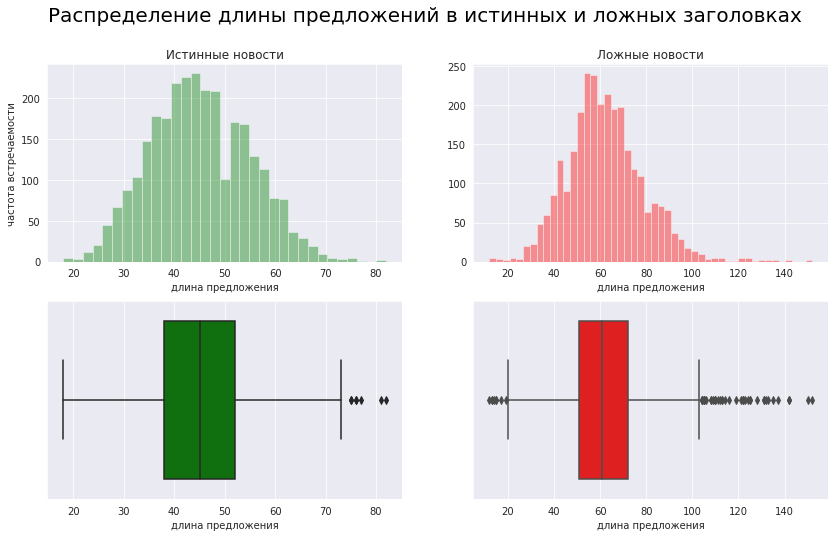

In [20]:
# Visualizing sentence length distribution of non-fake & fake news titles 

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Распределение длины предложений в истинных и ложных заголовках', fontsize=20, color='black')


sns.distplot(data[data['is_fake']==0]['sentence_length'], 
             kde=False, color='g', ax=axes[0,0]).set(xlabel='длина предложения', 
                                                     ylabel='частота встречаемости', 
                                                     title='Истинные новости')
sns.boxplot(data[data['is_fake']==0]['sentence_length'], ax=axes[1,0], color='g').set(xlabel='длина предложения')

sns.distplot(data[data['is_fake']==1]['sentence_length'], 
            kde=False, ax=axes[0,1], color='r').set(xlabel='длина предложения', title='Ложные новости') 
sns.boxplot(data[data['is_fake']==1]['sentence_length'], ax=axes[1,1], color='r').set(xlabel='длина предложения');

В обоих случая распределения близки к нормальным, но снова ложные новости отражают большее число выбросов. 

Посмотрим на границы этиъ выбросов и их количество:

In [21]:
# function defining the whiskers of a box-plot

def whiskers(data):
    upper_quartile = np.percentile(data, 75)
    lower_quartile = np.percentile(data, 25)

    iqr = upper_quartile - lower_quartile
    lower_whisker = data[data>=lower_quartile-1.5*iqr].min()
    upper_whisker = data[data<=upper_quartile+1.5*iqr].max()
    
    return [lower_whisker, upper_whisker]

Применим эту функции к полученным данным о количестве слов и длине предложений:

In [22]:
# Applying function to columns

columns = ['word_number', 'sentence_length']
for column in columns:
    print(column,  ':', whiskers(data[column]), '\n')

word_number : [3, 11] 

sentence_length : [12, 92] 



Посмотрим, какое число данных является выбросами:

In [23]:
# Counting the number of outliers

data_cut = data.query('92 >= sentence_length >= 12 & 11 >= word_number >= 3')
print('Потеря данных составит,', len(data) - len(data_cut), 'наблюдений.')

Потеря данных составит, 208 наблюдений.


In [24]:
data_cut['is_fake'].value_counts()

0    2875
1    2674
Name: is_fake, dtype: int64

В ряде ситуаций удаление 208 строк не столь значимо. НО! в нашем случае мы исключим 205 строк с фейковыми заголовками и частично лишим модели важной "пищи" для обучения. 

Как видим, длинные предложения - в определенной мере, это фишка фейковых новостей и значимое свойство, которое должно положительно повлиять на достижение более высокого скора.

Текстовые данные обработаны. Можно переходить к этапу подготовки к обучению.

## Preparation for ML

Сначала сформируем Baseline Model на основне Логистической регрессии и с использованием TfidfVectorizer().

* подготовим признаки 
* разделим данные на трейн и валид
* проведем векторизацию
* обучим модель и выведим результат метрики **F1**.

### Baseline Model

In [25]:
# Baseline mmodel variables

X_baseline = data['title']  
y_baseline = data['is_fake']

In [26]:
X_train_baseline, X_valid_baseline, y_train, y_valid = train_test_split(X_baseline, y_baseline, 
                                                                        test_size=0.3, random_state=0)

In [27]:
tf_idf = TfidfVectorizer() 

X_train_baseline_vect = tf_idf.fit_transform(X_train_baseline)
X_valid_baseline_vect = tf_idf.transform(X_valid_baseline)

print('Размер обучающей выборки: ', X_train_baseline_vect.shape)
print('Размер валидационой выборки: ', X_valid_baseline_vect.shape)

Размер обучающей выборки:  (4029, 14744)
Размер валидационой выборки:  (1728, 14744)


In [28]:
baseline_model = LogisticRegression().fit(X_train_baseline_vect, y_train)

baseline_preds = baseline_model.predict(X_valid_baseline_vect)
baseline_f1 = f1_score(y_valid, baseline_preds)

print('F1_score: ', baseline_f1.round(2))

F1_score:  0.82


Даже на сырых данных результат не такой уж и низкий. Посмотрим, что покажет "подкрутка" параметров и "чистые данные".

### Main models

Определеним переменные признаков и таргета. В нашем случае признак только один - это очищенные и лемматизированные текстовые данные. 

In [29]:
# Main variables for ML

X = data['lemm_text']  
y = data['is_fake']

Разделим датафрейм на две выборки:

In [30]:
# Splitting data

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

Для векторизации будем использовать **TfidfVectorizer**, а не **CountVectorizer**, чтобы избежать проблем со смещением в пользу наиболее частых слов и игнорированию редких. TfidfVectorizer поможет преодолеть эти трудности и более эффективно обработает данные.

Используя TfidfVectorizer, применим параметры *`ngram_range=(1, 2), use_idf=False`*, как оптимальные для выбранных моделей.

Векторизатор обучим только на тренировочной части данных, чтобы уменьшить переобучение.

In [31]:
# Vectorizing the feature

tf_idf = TfidfVectorizer(ngram_range=(1, 2), use_idf=False) 

X_train_vect = tf_idf.fit_transform(X_train)
X_valid_vect = tf_idf.transform(X_valid)

print('Размер обучающей выборки: ', X_train_vect.shape)
print('Размер валидационой выборки: ', X_valid_vect.shape)

Размер обучающей выборки:  (4029, 31338)
Размер валидационой выборки:  (1728, 31338)


Данные подготовленые, можно приступать к обучению.

**Для обучения было выбрано 5 моделей:**

1. `Логистическая регрессия;`
2. `Пассивно-агрессивный классификатор;`
3. `Полиномиальный наивный байесовский классификатор;`
4. `Метод опорных векторов;`
5. `Многослойный персептрон.`

Данные модели лучше подходят для поставленной задачи, чем деревянные или бустинговые модели.

Обучение моделей будет просиходить с использованием автоматического подбора параметров и кросс-валидации. По результатам вычислим сбалансированную оценку **F1**, а также полноту и точность прогонозов. Дополнительное визуализируем результат, построив матрицу путаницы.

 **`LogisticRegression`**

In [32]:
#LogisticRegression

model_lr = LogisticRegression(random_state=0)

params_lr = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
             'C': [5, 15, 25]
            }
grid_lr = GridSearchCV(model_lr, params_lr, 
                       scoring='f1', n_jobs=-1, cv=5, refit=True)
grid_lr.fit(X_train_vect, y_train)

preds_lr = grid_lr.predict(X_valid_vect)
recall_lr = recall_score(y_valid, preds_lr)
precision_lr = precision_score(y_valid, preds_lr)
f1_lr = f1_score(y_valid, preds_lr)

print('Полнота: ', recall_lr)
print('Точность: ', precision_lr)
print('F1_score: ', f1_lr, '\n')

best_params_lr = grid_lr.best_params_
print('Оптимальные параметры: ', best_params_lr)

Полнота:  0.8717948717948718
Точность:  0.8201754385964912
F1_score:  0.8451977401129944 

Оптимальные параметры:  {'C': 25, 'solver': 'newton-cg'}


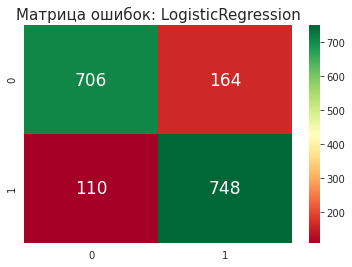

In [33]:
# Confusion matrix - LogisticRegression
sns.heatmap(confusion_matrix(y_valid, preds_lr), fmt='3.0f', annot=True, cmap='RdYlGn', annot_kws={'size':17})
plt.title('Матрица ошибок: LogisticRegression', size=15);

Результат несколько выше бейзлайна, но все-таки не достаточно. Тем не менее, модель неплохо определяет ложные новости, хотя и приписывает истинным новостям статут "ложности", теряя, тем самым, в точности.  

**`Passive Aggressive Classifier`**

In [34]:
# PassiveAggressiveClassifier

model_pac = PassiveAggressiveClassifier(shuffle=False, random_state=0)

params_pac = {'C': [10, 15, 25]}

grid_pac = GridSearchCV(model_pac, params_pac, 
                        scoring='f1', n_jobs=-1, cv=5, refit=True)
grid_pac.fit(X_train_vect, y_train)

preds_pac = grid_pac.predict(X_valid_vect)
recall_pac = recall_score(y_valid, preds_pac)
precision_pac = precision_score(y_valid, preds_pac)
f1_pac = f1_score(y_valid, preds_pac)


print('Полнота: ', recall_pac)
print('Точность: ', precision_pac)
print('F1_score: ', f1_pac, '\n')

best_params_pac = grid_pac.best_params_
print('Оптимальные параметры: ', best_params_pac)

Полнота:  0.8752913752913752
Точность:  0.8127705627705628
F1_score:  0.8428731762065095 

Оптимальные параметры:  {'C': 10}


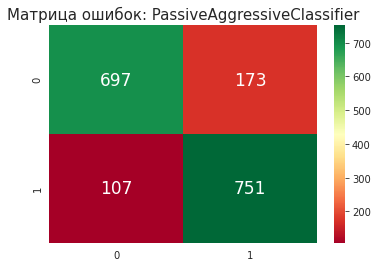

In [35]:
# Confusion matrix - PassiveAggressiveClassifier

sns.heatmap(confusion_matrix(y_valid, preds_pac), fmt='3.0f', annot=True, cmap='RdYlGn', annot_kws={'size':17})
plt.title('Матрица ошибок: PassiveAggressiveClassifier', size=15);

Практически такой же результат, как и с Логистичекой регрессией, только чуть больше ошибок второго рода.

**`MultinomialNB`**

In [36]:
# MultinomialNB

model_mnb = MultinomialNB()

params_mnb = {'alpha': [1e-1, 1e-3, 1e-6]
             }

grid_mnb = GridSearchCV(model_mnb, params_mnb,
                        scoring='f1', cv=5, refit=True)
grid_mnb.fit(X_train_vect, y_train)

preds_mnb = grid_mnb.predict(X_valid_vect)
recall_mnb = recall_score(y_valid, preds_mnb)
precision_mnb = precision_score(y_valid, preds_mnb)
f1_mnb = f1_score(y_valid, preds_mnb)

print('Полнота: ', recall_mnb)
print('Точность: ', precision_mnb)
print('F1_score: ', f1_mnb, '\n')

best_params_mnb = grid_mnb.best_params_
print('Оптимальные параметры: ', best_params_mnb)

Полнота:  0.9079254079254079
Точность:  0.8252118644067796
F1_score:  0.8645948945615981 

Оптимальные параметры:  {'alpha': 0.1}


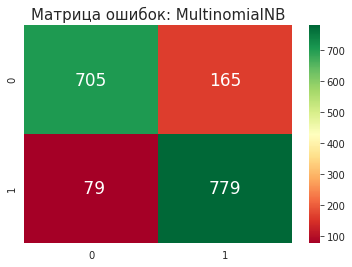

In [37]:
# Confusion matrix - MultinomialNB

sns.heatmap(confusion_matrix(y_valid, preds_mnb), fmt='3.0f', annot=True, cmap='RdYlGn', annot_kws={'size':17})
plt.title('Матрица ошибок: MultinomialNB', size=15);

Отличный результат - значительная часть заголовков ложных новостей спрогнозирована верно. При этом не наблюдается снижение точности.  

**`Support Vector Machine`**

In [38]:
# Support Vector Machine

model_svc = SVC() 
param_svc = {'C': [5, 10, 15], 
              'gamma': [1,0.1,0.01,0.001],
              'kernel': ['linear','sigmoid']
             }
grid_svc = GridSearchCV(model_svc, param_svc, scoring='f1', refit=True, cv=5, verbose=0)
grid_svc.fit(X_train_vect, y_train)


preds_svc = grid_svc.predict(X_valid_vect)
recall_svc = recall_score(y_valid, preds_svc)
precision_svc = precision_score(y_valid, preds_svc)
f1_svc = f1_score(y_valid, preds_svc)

print('Полнота: ', recall_svc)
print('Точность: ', precision_svc)
print('F1_score: ', f1_svc)

best_params_svc = grid_svc.best_params_
print('Оптимальные параметры: ', best_params_svc)

Полнота:  0.8752913752913752
Точность:  0.8198689956331878
F1_score:  0.846674182638106
Оптимальные параметры:  {'C': 15, 'gamma': 0.1, 'kernel': 'sigmoid'}


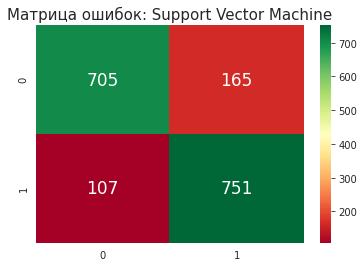

In [39]:
# Confusion matrix - Support Vector Machine

sns.heatmap(confusion_matrix(y_valid, preds_svc), fmt='3.0f', annot=True, cmap='RdYlGn', annot_kws={'size':17})
plt.title('Матрица ошибок: Support Vector Machine', size=15);

Результат схож с первыми двумя моделями - не слишком высокий показатель метрики **F1**.

**`MLPClassifier`**

Чтобы избежать "*one eternity later*", сделаем для данной модели исключение и прибегнем к ручному подбору гиперпараметров 🧮.

In [40]:
# MLPClassifier

model_mlp = MLPClassifier(hidden_layer_sizes=(7, 10, 7), batch_size=295, shuffle=False, random_state=0)

model_mlp.fit(X_train_vect, y_train)

preds_mlp = model_mlp.predict(X_valid_vect)
recall_mlp = recall_score(y_valid, preds_mlp)
precision_mlp = precision_score(y_valid, preds_mlp)
f1_mlp = f1_score(y_valid, preds_mlp)


print('Полнота: ', recall_mlp)
print('Точность: ', precision_mlp)
print('F1_score: ', f1_mlp)

Полнота:  0.9102564102564102
Точность:  0.8282078472958643
F1_score:  0.8672959466962797


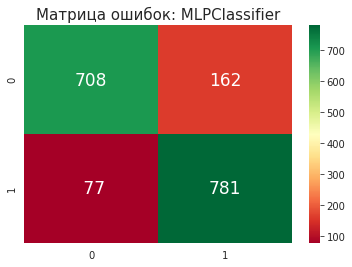

In [41]:
# Confusion matrix - MLPClassifier

sns.heatmap(confusion_matrix(y_valid, preds_mlp), fmt='3.0f', annot=True, cmap='RdYlGn', annot_kws={'size':17})
plt.title('Матрица ошибок: MLPClassifier', size=15);

Совсем немного (всего на несколько единиц), но нейронная модель оказалась чуть лучше байесовского классификатора. 

Построим для MLPClassifier AUC-ROC кривую: 

AUC-ROC: 0.9347667658012486



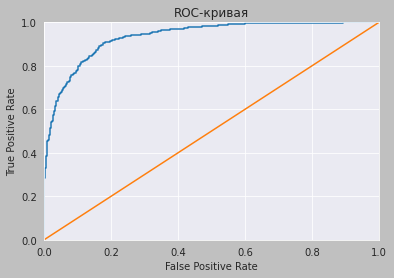

In [42]:
# AUC-ROC curve

probabilities_valid = model_mlp.predict_proba(X_valid_vect)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_valid = roc_auc_score(y_valid, probabilities_one_valid)
print('AUC-ROC:', auc_roc_valid)
print('')

fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)

plt.figure(facecolor='silver')
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('ROC-кривая');

Значение метрики AUC-ROC довольно высокое. Кривая достаточно сильно поднимается над линией случайного результата.  

Наша модель неплохо предсказывает класс "1": хорошо понимает, какие заголовки являются ложными. Несколько хуже результат с классом "0": ложноположительных значений в два раза больше, чем ложноотрицательных. И все же, если мы постараемся улучшить точность, то начнем терять в полноте - такой вариант не подходит, так как важнее вычленить фейки.

### Result

Сведем все результаты в одну таблицу и сортируем данные по убыванию относително f1-score:

In [43]:
# Resulting table

score_table = pd.DataFrame(data=[[f1_lr, recall_lr, precision_lr], 
                                [f1_pac, recall_pac, precision_pac],
                                [f1_svc, recall_svc, precision_svc],
                                [f1_mnb, recall_mnb, precision_mnb], 
                                [f1_mlp, recall_mlp, precision_mlp]],
                      columns = ['f1_score', 'Recall', 'Precision'], 
                      index = ['LogReg', 'PasAgg', 'SVC', 'MNB',  'MLP']).sort_values(by='f1_score', ascending=False)
score_table

,f1_score,Recall,Precision
MLP,0.867296,0.910256,0.828208
MNB,0.864595,0.907925,0.825212
SVC,0.846674,0.875291,0.819869
LogReg,0.845198,0.871795,0.820175
PasAgg,0.842873,0.875291,0.812771


Визуализируем значение метрики **F1** для каждой модели:

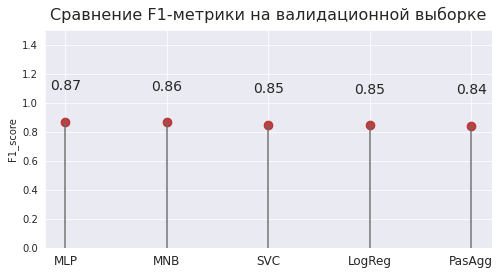

In [44]:
# F1-score visualisation 

def scores(data):
    fig, ax = plt.subplots(figsize=(8,4))
   
    ax.vlines(x=data.index, ymin=0, ymax=data['f1_score'], color='dimgrey', alpha=0.7, linewidth=2)
    ax.scatter(x=data.index, y=data['f1_score'], s=75, color='firebrick', alpha=0.85)
   
    ax.set_title('Сравнение F1-метрики на валидационной выборке', size=16, y=(1.02))
    ax.set_ylabel('F1_score')
    ax.set_ylim(0, 1.5)
    ax.set_xticks(data.index)
    ax.set_xticklabels(data.index, rotation=0, fontdict={'horizontalalignment': 'center', 'size':12})

    for row in data.itertuples():
        ax.text(row.Index, row.f1_score +.2, s=round(row.f1_score, 2), 
           horizontalalignment= 'center', verticalalignment='bottom', fontsize=14);
        
scores(score_table)

Байесовский классификатор и нейронная модель идут практически вровень, но MLPClassifier() чуть лучше. На данной модели и остановим свой выбор, чтобы спрогнозировать ложность & истинность заголовков новостей тестовых данных. 

Итак, перейдем к итоговой части проекта - работе модели в полевых условиях. 

## Predictions & results

Финальная часть проекта. 

Для предасказаний мы будем использовать модель многослойного перцептрона с установленными гиперпараметрами.

### Importing and reading test data

Загрузим тестовые данные

In [45]:
# Reading test dataset

predictions = pd.read_csv('test.tsv', sep='\t')

In [46]:
predictions.head()

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,0
1,Ночью под Минском на президентской горе Белара...,0
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,0
3,"Сельская церковь, собравшая рекордно низкое ко...",0
4,Акции Google рухнули после объявления о переза...,0


In [47]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1000 non-null   object
 1   is_fake  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


Данный датасет значительно меньше - всего 1000 строк.

### Preprocessing 

Обработаем тектовые данные с помощью имеющей функции препроцессинга.

In [48]:
# Preprocessing textual data

predictions['lemm_text'] = predictions['title'].apply(preprocessing) 

### Vectorizing

Подготовим данные к обучению.

In [49]:
# Vectorizing the feature

X_test = predictions['lemm_text']
X_test = tf_idf.transform(X_test)

### Predicting

Используя модель MLPClassifier() с определенными гиперпараметрами сделаем предсказание классов:

In [50]:
# Making predictions

predictions['is_fake'] = model_mlp.predict(X_test)

### Results 

Удалим ненужный более столбец обработанных текстовых данных:

In [51]:
del predictions['lemm_text']

Посмотрим на полученный результат:

In [52]:
predictions.head()

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,1
1,Ночью под Минском на президентской горе Белара...,1
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,1
3,"Сельская церковь, собравшая рекордно низкое ко...",1
4,Акции Google рухнули после объявления о переза...,1


1    547
0    453
Name: is_fake, dtype: int64 



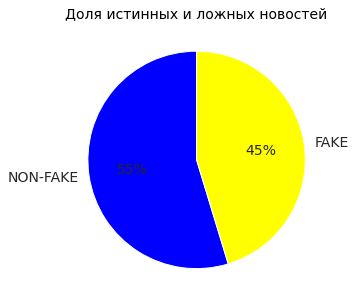

In [53]:
# Fake amd non-fake news title ratio - test data

ratio = predictions['is_fake'].value_counts()
print(ratio, '\n');

plt.figure(figsize=(5,5))
plt.title('Доля истинных и ложных новостей', fontsize=14, color='black')

labels=['NON-FAKE', 'FAKE']
ratio.plot(kind='pie', startangle=90, textprops={'fontsize': 14},
           labels=labels, autopct = '%0.0f%%', colors = ['blue', 'yellow'])
plt.ylabel('');

### Exporting final file

In [54]:
# Exporting file

predictions.to_csv('predictions.tsv', sep='\t', index=False)

## Conclusion

Мы загрузили оба имющихся файла. Написали функцию предобработки текстовой информации и использовали ее для обучающей, валидационной и тестовой выборок. 

Векторезировали данные с помощью TfidfVectorizer(). Проверили качество предсказаний на нескольких моделях. В результате лучшей окзалась модель MLPClassifier. Удалось достичь показания метрики F1, равное 0.87. Также положительным результатом можно считать, способность модели точнее выявлять заголовки ложных новостей, что снижает вероятность пропустить фейковые данные. 

Модель была использована для предсказания заголовков реальных и выдуманных новостей на тестовом датасете. Результат был экспортирован в отдельный файл. 

<img src="https://miro.medium.com/focal/116/116/50/50/1*9wEfSMQ93nMWyBq8HdtVow.jpeg" width="200">